
## CycleGAN Brief

CycleGAN is unpaired image-to-image translation task from $A$ to $B$ and represented by two generative networks $G$ and $F$:
$$
\hat{y} = G(x) \in B,\text{ for } x \in A \\
\hat{x} = F(y) \in A,\text{ for } y \in B
$$

and two discriminators $D_A$ and $D_B$. Training of the networks is done by minimizing the loss is a sum of 3 components:
$$
\mathcal{L}(G, F, D_A, D_B) = \mathcal{L}_{GAN}(G, D_B) + \mathcal{L}_{GAN}(F, D_A) + \lambda \mathcal{L}_{cyc}(G, F)
$$
with GAN loss:
$$
\mathcal{L}_{GAN}(G, D_B) = \text{mean}_{x \in A}\left[ (D_B(G(x)) - 1)^2 \right]+ \text{mean}_{y \in B}\left[ (D_B(y) - 1)^2 \right] \\
\mathcal{L}_{GAN}(F, D_A) = \text{mean}_{y \in B}\left[ (D_A(F(y)) - 1)^2 \right]+ \text{mean}_{x \in A}\left[ (D_A(x) - 1)^2 \right]
$$
and forward and backward cycle consistency term:
$$
\mathcal{L}_{cyc}(G, F) = \text{mean}_{x \in A}\left[ |F(G(x)) - x|_1 \right] + \text{mean}_{y \in B}\left[ |G(F(y)) - y|_1 \right]
$$



## Import necessary packages


In [ ]:
import torch
import ignite
import random
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from ignite.engine import Engine, Events
from ignite.metrics import RunningAverage,FID,InceptionScore, SSIM

from ignite.contrib.handlers import TensorboardLogger, WandBLogger
from ignite.contrib.handlers.wandb_logger import OptimizerParamsHandler as wbop, OutputHandler as wboh

from ignite.contrib.handlers.tensorboard_logger import OutputHandler, OptimizerParamsHandler
import matplotlib.pylab as plt
%matplotlib inline

## Data Loading and Pre-processing

In [ ]:

class FilesDataset(Dataset):
    
    def __init__(self, path, extension="*.png"):
        self.path = Path(path)
        assert self.path.exists(), "Path '{}' is not found".format(path)
        self.images = list(self.path.rglob(extension))
        assert len(self.images) > 0, "No images with extension {} found at '{}'".format(extension, path)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, i):
        return Image.open(self.images[i]).convert('RGB')


class FilesDataset2(Dataset):
    
    def __init__(self, path, extension="*.jpg"):
        self.path = Path(path)
        assert self.path.exists(), "Path '{}' is not found".format(path)
        self.images = list(self.path.rglob(extension))
        assert len(self.images) > 0, "No images with extension {} found at '{}'".format(extension, path)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, i):
        return Image.open(self.images[i]).convert('RGB')        

In [ ]:
from pathlib import Path

root = Path("pizza")
#Datasets
live_train = FilesDataset("/common/home/jrp328/Downloads/Cyclegan/dataset/live train")
real_train = FilesDataset2("/common/home/jrp328/Downloads/Cyclegan/dataset/real train")

live_test = FilesDataset("/common/home/jrp328/Downloads/Cyclegan/dataset/live test") 
real_test = FilesDataset2("/common/home/jrp328/Downloads/Cyclegan/dataset/real test")

#### Dataset details:

In [ ]:
print("Dataset sizes: \n Live Pizza Train: {} | Real Pizza Train: {}\n Live Pizza Test: {} | Real Pizza Test: {}\n\t".format(len(live_train), len(real_train), len(live_test), len(real_test)))

Dataset sizes: 
 Live Pizza Train: 100 | Real Pizza Train: 100
 Live Pizza Test: 100 | Real Pizza Test: 100
	


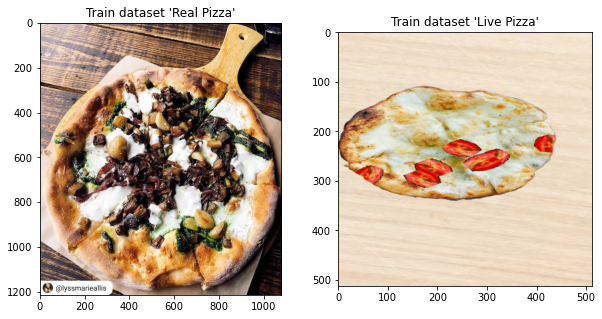

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("Train dataset 'Real Pizza'")
plt.imshow(real_train[10])
plt.subplot(122)
plt.title("Train dataset 'Live Pizza'")
plt.imshow(live_train[10])

#### Dataset composed of random image pairs of datasets A and B

In [ ]:
import random


class Image2ImageDataset(Dataset):
    
    def __init__(self, ds_a, ds_b):
        self.dataset_a = ds_a
        self.dataset_b = ds_b
    
    def __len__(self):
        return max(len(self.dataset_a), len(self.dataset_b))

    def __getitem__(self, i):
        dp_a = self.dataset_a[i % len(self.dataset_a)]
        j = random.randint(0, len(self.dataset_b) - 1)
        dp_b = self.dataset_b[j]
        return {
            'A': dp_a,
            'B': dp_b
        }


class TransformedDataset(Dataset):
        
    def __init__(self, ds, transform):
        self.dataset = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, i):
        return {k: self.transform(v) for k, v in self.dataset[i].items()}

In [ ]:
train_ab_ds = Image2ImageDataset(live_train, real_train)
test_ab_ds = Image2ImageDataset(live_test,real_test)

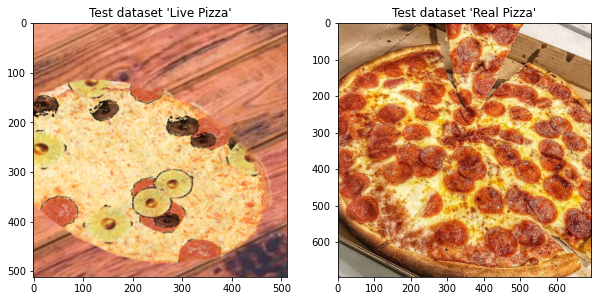

In [ ]:
dp = test_ab_ds[20]

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("Test dataset 'Live Pizza'")
plt.imshow(dp['A'])
plt.subplot(122)
plt.title("Test dataset 'Real Pizza'")
plt.imshow(dp['B'])

#### Pre-processing

In [ ]:
from torchvision.transforms import Compose, ColorJitter, RandomHorizontalFlip, ToTensor, Normalize, RandomCrop,Resize

# here we are resizing to scale images which are not of size 256*256 to accomodate them 
train_transform = Compose([
    Resize(256),                 
    RandomCrop(256),
    RandomHorizontalFlip(),
    ColorJitter(),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
transformed_train_ab_ds = TransformedDataset(train_ab_ds, transform=train_transform)


batch_size = 1
train_ab_loader = DataLoader(transformed_train_ab_ds, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)


test_transform = Compose([
    Resize(256),
    RandomCrop(256),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
transformed_test_ab_ds = TransformedDataset(test_ab_ds, transform=test_transform)
batch_size = 1
test_ab_loader = DataLoader(transformed_test_ab_ds, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=4)

## Generator Architecture

- Generator network architecture contains 9 residual blocks

Using paper's notations:
```
c7s1-64,d128,d256,R256,R256,R256,R256,R256,R256,R256,R256,R256,u128,u64,c7s1-3,tanh
```
where `c7s1-k` denotes a 7x7 Convolution-InstanceNorm-ReLU layer with `k` filters and stride 1. `dk` denotes a 3x3 Convolution-InstanceNorm-ReLU layer  with `k` filters and stride 2. Reflection padding was used to reduce artifacts. `Rk` denotes a residual block that contains two 3x3 convolutional layers with the same number of filters on both layer. `uk` denotes a 3x3 fractional-strided-Convolution-InstanceNorm-ReLU layer with `k` filters and stride 1/2.

In [ ]:
import torch
import torch.nn as nn


def get_conv_inorm_relu(in_planes, out_planes, kernel_size, stride, reflection_pad=True, with_relu=True):
    layers = []
    padding = (kernel_size - 1) // 2
    if reflection_pad:
        layers.append(nn.ReflectionPad2d(padding=padding))
        padding = 0
    layers += [
        nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.InstanceNorm2d(out_planes, affine=False, track_running_stats=False),
    ]
    if with_relu:
        layers.append(nn.ReLU(inplace=True))
    return nn.Sequential(*layers)


def get_conv_transposed_inorm_relu(in_planes, out_planes, kernel_size, stride):
    return nn.Sequential(
        nn.ConvTranspose2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=1, output_padding=1),
        nn.InstanceNorm2d(out_planes, affine=False, track_running_stats=False),
        nn.ReLU(inplace=True)
    )


class ResidualBlock(nn.Module):
    
    def __init__(self, in_planes):
        super(ResidualBlock, self).__init__()
        self.conv1 = get_conv_inorm_relu(in_planes, in_planes, kernel_size=3, stride=1)
        self.conv2 = get_conv_inorm_relu(in_planes, in_planes, kernel_size=3, stride=1, with_relu=False)        

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.conv2(x)        
        return x + residual


class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.c7s1_64 = get_conv_inorm_relu(3, 64, kernel_size=7, stride=1)
        self.d128 = get_conv_inorm_relu(64, 128, kernel_size=3, stride=2, reflection_pad=False)
        self.d256 = get_conv_inorm_relu(128, 256, kernel_size=3, stride=2, reflection_pad=False)

        self.resnet9 = nn.Sequential(*[ResidualBlock(256) for i in range(9)])

        self.u128 = get_conv_transposed_inorm_relu(256, 128, kernel_size=3, stride=2)
        self.u64 = get_conv_transposed_inorm_relu(128, 64, kernel_size=3, stride=2)
        self.c7s1_3 = get_conv_inorm_relu(64, 3, kernel_size=7, stride=1, with_relu=False)
        # Replace instance norm by tanh activation
        self.c7s1_3[-1] = nn.Tanh()

    def forward(self, x):
        # Encoding
        x = self.c7s1_64(x)
        x = self.d128(x)
        x = self.d256(x)
        
        # 9 residual blocks
        x = self.resnet9(x)

        # Decoding
        x = self.u128(x)
        x = self.u64(x)
        y = self.c7s1_3(x)
        return y


## Discriminator Architecture

- Discriminator network is a PatchGAN (with receptive field 70x70):
```
C64-C128-C256-C512
```
where `Ck` denote a 4x4 Convolution-InstanceNorm-LeakyReLU layer with `k` filters and stride 2. After the last layer, 
a convolution to produce a 1-dimensional output is applied. No `InstanceNorm` for the first `C64` layer. Leaky ReLUs are with a slope of `0.2`. 


```
In fact, a "PatchGAN" is just a convnet! Or you could say all convnets are patchnets: the power of convnets is that they process each image patch identically and independently, which makes things very cheap (# params, time, memory), and, amazingly, turns out to work.

The difference between a PatchGAN and regular GAN discriminator is that rather the regular GAN maps from a 256x256 image to a single scalar output, which signifies "real" or "fake", whereas the PatchGAN maps from 256x256 to an NxN array of outputs X, where each X_ij signifies whether the patch ij in the image is real or fake. Which is patch ij in the input? Well, output X_ij is just a neuron in a convnet, and we can trace back its receptive field to see which input pixels it is sensitive to. In the CycleGAN architecture, the receptive fields of the discriminator turn out to be 70x70 patches in the input image!

This is all mathematically equivalent to if we had manually chopped up the image into 70x70 overlapping patches, run a regular discriminator over each patch, and averaged the results.

```

Source:[this comment](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/issues/39#issuecomment-305575964):

In [ ]:
def get_conv_inorm_lrelu(in_planes, out_planes, stride=2, negative_slope=0.2):
    return nn.Sequential(
        nn.Conv2d(in_planes, out_planes, kernel_size=4, stride=stride, padding=1),
        nn.InstanceNorm2d(out_planes, affine=False, track_running_stats=False),
        nn.LeakyReLU(negative_slope=negative_slope, inplace=True)
    )


class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.c64 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.c128 = get_conv_inorm_lrelu(64, 128)
        self.c256 = get_conv_inorm_lrelu(128, 256)
        self.c512 = get_conv_inorm_lrelu(256, 512, stride=1)
        self.last_conv = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)

    def forward(self, x):
        x = self.c64(x)
        x = self.relu(x)

        x = self.c128(x)
        x = self.c256(x)
        x = self.c512(x)
        y = self.last_conv(x)
        return y


#### Weights are initialized from a Gaussian distribution $\mathcal{N}(0,0.02)$

In [ ]:
def init_weights(module):
    assert isinstance(module, nn.Module)
    if hasattr(module, "weight") and module.weight is not None:
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    if hasattr(module, "bias") and module.bias is not None:
        torch.nn.init.constant_(module.bias, 0.0)
    for c in module.children():
        init_weights(c)

g = None; d = None

## Networks training

In [ ]:
assert torch.backends.cudnn.enabled
torch.backends.cudnn.benchmark = True

#### Intialize the models with weights

In [ ]:
# device = "cuda"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator_A2B = Generator().to(device)
init_weights(generator_A2B)

discriminator_B = Discriminator().to(device)
init_weights(discriminator_B)

generator_B2A = Generator().to(device)
init_weights(generator_B2A)
discriminator_A = Discriminator().to(device)
init_weights(discriminator_A)

#### Train the networks with a learning rate of `0.0002`.

In [ ]:
from itertools import chain
import torch.optim as optim

#leaning rate
lr = 0.0002

beta1 = 0.5

# optimizer
optimizer_G = optim.Adam(chain(generator_A2B.parameters(), generator_B2A.parameters()), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(chain(discriminator_A.parameters(), discriminator_B.parameters()), lr=lr, betas=(beta1, 0.999))

Let's define some helper functions:
- to turn on/off gradients

In [ ]:
def toggle_grad(model, on_or_off):
    # https://github.com/ajbrock/BigGAN-PyTorch/blob/master/utils.py#L674
    for param in model.parameters():
        param.requires_grad = on_or_off

### Fake images buffer trick

As per the paper, to reduce model oscillation and the discriminators are updated using a history of generated images rather than the ones produced by the latest generators. 

There is an image buffer that stores the X previously created images.

In [ ]:
buffer_size = 50
fake_a_buffer = []
fake_b_buffer = []


def buffer_insert_and_get(buffer, batch):
    output_batch = []
    for b in batch:
        b = b.unsqueeze(0)
        # if buffer is not fully filled:
        if len(buffer) < buffer_size:
            output_batch.append(b)
            buffer.append(b.cpu())
        elif random.uniform(0, 1) > 0.5:
            # Add newly created image into the buffer and put ont from the buffer into the output
            random_index = random.randint(0, buffer_size - 1)            
            output_batch.append(buffer[random_index].clone().to(device))
            buffer[random_index] = b.cpu()
        else:
            output_batch.append(b)
    return torch.cat(output_batch, dim=0)

## Loss functions 
As suggested, we divide the objective by 2 while optimizing D, which slows down the rate at which D learns, relative to the rate of G. 

According to the paper:
- generator A is trained  minimize $\text{mean}_{x \in A}[(D_B(G(x)) − 1)^2]$ and cycle loss $\text{mean}_{x \in A}\left[ |F(G(x)) - x|_1 \right]$
- generator B is trained  minimize $\text{mean}_{y \in B}[(D_A(F(y)) − 1)^2]$ and cycle loss $\text{mean}_{y \in B}\left[ |G(F(y)) - y|_1 \right]$
- discriminators A is trained to minimize $\text{mean}_{x \in A}[(D_A(x) − 1)^2] + \text{mean}_{y \in B}[D_A(F(y))^2]$.
- discriminator B is trained to minimize $\text{mean}_{y \in B}[(D_B(y) − 1)^2] + \text{mean}_{x \in A}[D_B(G(x))^2]$.

In [ ]:
import torch
import torchvision

# VGG Perceptual Loss
class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        blocks.append(torchvision.models.vgg16(pretrained=True).features[:4].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[4:9].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[9:16].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[16:23].eval())
        for bl in blocks:
            for p in bl.parameters():
                p.requires_grad = False
        self.blocks = torch.nn.ModuleList(blocks)
        self.transform = torch.nn.functional.interpolate
        self.resize = resize
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, input, target, feature_layers=[0, 1, 2, 3], style_layers=[]):
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
        input = (input-self.mean) / self.std
        target = (target-self.mean) / self.std
        if self.resize:
            input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
            target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        loss = 0.0
        x = input
        y = target
        for i, block in enumerate(self.blocks):
            x = block(x)
            y = block(y)
            if i in feature_layers:
                loss += torch.nn.functional.l1_loss(x, y)
            if i in style_layers:
                act_x = x.reshape(x.shape[0], x.shape[1], -1)
                act_y = y.reshape(y.shape[0], y.shape[1], -1)
                gram_x = act_x @ act_x.permute(0, 2, 1)
                gram_y = act_y @ act_y.permute(0, 2, 1)
                loss += torch.nn.functional.l1_loss(gram_x, gram_y)
        return loss


In [ ]:
from torch.cuda.amp import autocast, GradScaler

from ignite.utils import convert_tensor
import torch.nn.functional as F

amp_enabled = True
lambda_value = 10.0
amp_scaler = GradScaler(enabled=amp_enabled)
max_epochs = 100
vgg_loss = VGGPerceptualLoss().to(device)

def discriminator_forward_pass(discriminator, batch_real, batch_fake, fake_buffer):
    decision_real = discriminator(batch_real)
    batch_fake = buffer_insert_and_get(fake_buffer, batch_fake)      
    decision_fake = discriminator(batch_fake)
    return decision_real, decision_fake


def compute_loss_generator(batch_decision, batch_real, batch_rec, lambda_value, epoch_no = 1):
    # loss gan
    target = torch.ones_like(batch_decision)
    loss_gan = F.mse_loss(batch_decision, target)
    # loss cycle
    loss_cycle = F.l1_loss(batch_real, batch_rec) * lambda_value
    #style_loss
    if epoch_no <= 30:
      style_weight = 0
    elif epoch_no <= 40:
      style_weight = 0.1
    elif epoch_no <= 60:
      style_weight = 0.15
    elif epoch_no <= 80:
      style_weight = 0.2
    elif epoch_no <= 100:
      style_weight = 0.25
    else:
      style_weight = 0.3
    style_loss = vgg_loss(batch_real, batch_rec)
    return loss_gan + (1-style_weight)*loss_cycle + style_weight*style_loss, style_loss


def compute_loss_discriminator(decision_real, decision_fake):
    # loss = mean (D_b(y) − 1)^2 + mean D_b(G(x))^2    
    loss = F.mse_loss(decision_fake, torch.zeros_like(decision_fake))
    loss += F.mse_loss(decision_real, torch.ones_like(decision_real))
    return loss


def update_fn(engine, batch):
    generator_A2B.train()
    generator_B2A.train()
    discriminator_A.train()
    discriminator_B.train()    

    real_a = convert_tensor(batch['A'], device=device, non_blocking=True)
    real_b = convert_tensor(batch['B'], device=device, non_blocking=True)

    # Update generators

    # Disable grads computation for the discriminators:
    toggle_grad(discriminator_A, False)
    toggle_grad(discriminator_B, False)    

    with autocast(enabled=amp_enabled):
        fake_b = generator_A2B(real_a)
        rec_a = generator_B2A(fake_b)
        fake_a = generator_B2A(real_b)
        rec_b = generator_A2B(fake_a)
        decision_fake_a = discriminator_A(fake_a)
        decision_fake_b = discriminator_B(fake_b)

        # Compute loss for generators and update generators
        loss_a2b , style_loss_a2b= compute_loss_generator(decision_fake_b, real_a, rec_a, lambda_value, engine.state.epoch)    

        loss_b2a, style_loss_b2a = compute_loss_generator(decision_fake_a, real_b, rec_b, lambda_value, engine.state.epoch)

        # total generators loss:
        loss_generators = loss_a2b + loss_b2a

    optimizer_G.zero_grad()
    amp_scaler.scale(loss_generators).backward()
    amp_scaler.step(optimizer_G)

    decision_fake_a = rec_a = decision_fake_b = rec_b = None
    
    # Enable grads computation for the discriminators:
    toggle_grad(discriminator_A, True)
    toggle_grad(discriminator_B, True)    

    with autocast(enabled=amp_enabled):
        decision_real_a, decision_fake_a = discriminator_forward_pass(discriminator_A, real_a, fake_a.detach(), fake_a_buffer)    
        decision_real_b, decision_fake_b = discriminator_forward_pass(discriminator_B, real_b, fake_b.detach(), fake_b_buffer)    
        # Compute loss for discriminators and update discriminators
        loss_a = compute_loss_discriminator(decision_real_a, decision_fake_a)

        loss_b = compute_loss_discriminator(decision_real_b, decision_fake_b)
      
        # total discriminators loss:
        loss_discriminators = 0.5 * (loss_a + loss_b)
    
    optimizer_D.zero_grad()
    amp_scaler.scale(loss_discriminators).backward()
    amp_scaler.step(optimizer_D)
    amp_scaler.update()
    
    return {
        "loss_generators": loss_generators.item(),
        "loss_generator_a2b": loss_a2b.item(),
        "loss_generator_b2a": loss_b2a.item(),
        "loss_discriminators": loss_discriminators.item(),
        "loss_discriminator_a": loss_a.item(),
        "loss_discriminator_b": loss_b.item(),
        "style_loss_a2b" : style_loss_a2b.item(),
        "style_loss_b2a" : style_loss_b2a.item(),
    }

We define a trainer and some handlers:
- log to tensorboard: losses, lr, generated images
- progress bar
- models/optimizers checkpointing



In [ ]:
!wandb login b657422595177149e90b8966412e2e8b1c783041

wandb: Appending key for api.wandb.ai to your netrc file: /common/home/jrp328/.netrc


In [ ]:
from ignite.engine import Engine, Events
from ignite.metrics import RunningAverage,FID,InceptionScore, SSIM

from ignite.contrib.handlers import TensorboardLogger, WandBLogger
from ignite.contrib.handlers.wandb_logger import OptimizerParamsHandler as wbop, OutputHandler as wboh

from ignite.contrib.handlers.tensorboard_logger import OutputHandler, OptimizerParamsHandler

### Metrics
#### FID, Inception Score, SSIM 


In [ ]:
fid_metric = FID(device=device)
is_metric = InceptionScore(device=device, output_transform=lambda x: x[0])
ssim_metric = SSIM(device=device, data_range=1.0)

fid_metric_1 = FID(device=device)
is_metric_1 = InceptionScore(device=device, output_transform=lambda x: x[0])
ssim_metric_1 = SSIM(device = device, data_range=1.0)

In [ ]:
from functools import partial
trainer = Engine(update_fn)

metric_names = [
    'loss_discriminators', 
    'loss_generators', 
    'loss_discriminator_a',
    'loss_discriminator_b',
    'loss_generator_a2b',
    'loss_generator_b2a' ,
    'style_loss_a2b',
    'style_loss_b2a'  
]

def output_transform(out, name):
    return out[name]

for name in metric_names:
    # here we cannot use lambdas as they do not store argument `name`
    RunningAverage(output_transform=partial(output_transform, name=name)).attach(trainer, name)


#### Weights and Biases Logging 

In [ ]:
from pathlib import Path
try:
    wb_run_name = "cycle_gan_live_pizzas_novel_approach_1_run2"
    wb_dir = Path("./cycle_gan_novel_run2")
    if not wb_dir.exists():
        wb_dir.mkdir()
    wandb_logger = WandBLogger(
        project="cycle_gan_live_pizzas_novel_approach_1",
        config={"max_epochs": 100},
        tags=["cycle_gan", "pizza"],
        name=wb_run_name,
        sync_tensorboard=True,
        dir=wb_dir.as_posix(),
        reinit=True
    )

except RuntimeError:
    wandb_logger = None

In [ ]:
wandb_logger.attach(
    trainer,
    log_handler=wboh(
        tag="training",
        metric_names=metric_names,
        global_step_transform=lambda *_: trainer.state.epoch,
    ),
    event_name=Events.EPOCH_COMPLETED
)

## used for logging graidents of the model while training  after evey 100 batches of training
wandb_logger.watch(generator_A2B,criterion=None,log='gradients',idx=1,log_freq=1000)
wandb_logger.watch(generator_B2A,criterion=None, log='gradients',idx=2,log_freq=1000)
wandb_logger.watch(discriminator_A,log='gradients',idx=3,log_freq=1000)
wandb_logger.watch(discriminator_B,log='gradients',idx=4,log_freq=1000)

Evaluator to inference on train/test images and log the generated images to Tensorboard:

In [ ]:
from ignite.engine import Engine

def evaluate_fn(engine, batch):
    generator_A2B.eval()
    generator_B2A.eval()    
    with torch.no_grad():
        real_a = convert_tensor(batch['A'], device=device, non_blocking=True)
        real_b = convert_tensor(batch['B'], device=device, non_blocking=True)
        
        fake_b = generator_A2B(real_a)
        rec_a = generator_B2A(fake_b)

        fake_a = generator_B2A(real_b)
        rec_b = generator_A2B(fake_a)
        
    return {
        'real_a': real_a,
        'real_b': real_b,
        'fake_a': fake_a,
        'fake_b': fake_b,
        'rec_a': rec_a,
        'rec_b': rec_b,        
    }


evaluator = Engine(evaluate_fn)

In [ ]:
from torch.utils.data import Subset

eval_batch_size = 4

train_random_indices = [random.randint(0, len(train_ab_ds) - 1) for _ in range(eval_batch_size)]
small_train_ds = Subset(train_ab_ds, train_random_indices)
small_train_ds = TransformedDataset(small_train_ds, transform=test_transform)

test_random_indices = [random.randint(0, len(test_ab_ds) - 1) for _ in range(eval_batch_size)]
small_test_ds = Subset(test_ab_ds, test_random_indices)
small_test_ds = TransformedDataset(small_test_ds, transform=test_transform)

eval_train_loader = DataLoader(small_train_ds, batch_size=eval_batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=4)
eval_test_loader = DataLoader(small_test_ds, batch_size=eval_batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=4)

In [ ]:
log_epoch = 1
import pickle
import os
fid_values = []
is_values = []

fid_values_1 = []
is_values_1 = []


@trainer.on(Events.EPOCH_COMPLETED)
def run_evaluation(engine):
    print(f'epoch done::',engine.state.epoch)
    log_epoch=engine.state.epoch
    # evaluator.run(eval_train_loader)
    evaluator.run(eval_test_loader)

def normalize(x):
    vmin = x.min()
    vmax = x.max()
    x.clamp_(min=vmin, max=vmax)
    x.add_(-vmin).div_(vmax - vmin + 1e-5)
    return x

id =0
def gen_submit_images(images):
    global id 
    os.makedirs('./images', exist_ok=True)

    id+=1
    for i,gen_img in enumerate(images):

        gen_img = (255 * normalize(gen_img[0, ...])).cpu().numpy().transpose((1, 2, 0)).astype('uint8')
                
        gen_img = Image.fromarray(gen_img)
        gen_img.save(os.path.join('./images', id))
        



def log_generated_images(engine, logger, event_name):

    tag = "Train" if engine.state.dataloader == eval_train_loader else "Test"
    output = engine.state.output
    state = trainer.state
    global_step = state.get_event_attrib_value(event_name)

    # fid metrics
    fid_metric.update((output['fake_a'], output['real_a']))
    gen_a_fid =fid_metric.compute()

    fid_metric_1.update((output['fake_b'], output['real_b']))
    gen_b_fid =fid_metric_1.compute()
    
    # inception socres
    is_metric.update(output['fake_a'])
    gen_a_is =is_metric.compute()

    is_metric_1.update(output['fake_b'])
    gen_b_is =is_metric_1.compute()
    
    # ssim metrics
    ssim_metric.update((output['fake_a'], output['real_a']))
    gen_a_ssim = ssim_metric.compute()
    
    ssim_metric_1.update((output['fake_b'], output['real_b']))
    gen_b_ssim = ssim_metric_1.compute()

    eval_metrics = {
        "gen_a_fid_w":gen_a_fid,
        "gen_b_fid_w":gen_b_fid,
         "gen_a_is_w": gen_a_is,
         "gen_b_is_w":gen_b_is,
         "gen_a_sism_w" : gen_a_ssim,
         "gen_b_sism_w" : gen_b_ssim
    }
    wandb_logger.log(eval_metrics)
    # gen_submit_images(output['fake_a'])
    curr= trainer.state.epoch
    print('current epoch number',curr)

    print(f'Epoch {engine.state.epoch} Metrics FID Forward : {gen_a_fid} FID Backwards :{gen_b_fid} IS Forward :{gen_a_is} IS Backward: {gen_b_is} ')

#### Suggested lr scheduling
The same learning rate for the first 100 epochs and linearly decay the rate to zero over the next 100 epochs.

In [ ]:
from ignite.contrib.handlers import PiecewiseLinear, ParamGroupScheduler


lr = 0.0002

milestones_values = [
    (0, lr),
    (50, lr),
    (100, 0.0)
]
gen_lr_scheduler = PiecewiseLinear(optimizer_D, param_name='lr', milestones_values=milestones_values)
desc_lr_scheduler = PiecewiseLinear(optimizer_G, param_name='lr', milestones_values=milestones_values)

lr_scheduler = ParamGroupScheduler([gen_lr_scheduler, desc_lr_scheduler], 
                                   names=['gen_lr_scheduler', 'desc_lr_scheduler'])

trainer.add_event_handler(Events.EPOCH_STARTED, lr_scheduler)

#### Models/optimizers checkpointing:

In [ ]:
from ignite.handlers import ModelCheckpoint, TerminateOnNan
checkpoint_handler = ModelCheckpoint(dirname="/common/home/jrp328/Downloads/cycle_gan/cycle_gan/cycle_gan/exp2/models", filename_prefix="epoch_", create_dir=True,n_saved=200)
to_save = {
    "generator_A2B": generator_A2B,
    "discriminator_B": discriminator_B,
    "generator_B2A": generator_B2A,
    "discriminator_A": discriminator_A,
    "optimizer_G": optimizer_G,
    "optimizer_D": optimizer_D,
}
trainer.add_event_handler(Events.EPOCH_COMPLETED(every=2), checkpoint_handler, to_save)
trainer.add_event_handler(Events.EPOCH_COMPLETED, TerminateOnNan())

In [ ]:
from ignite.contrib.handlers import ProgressBar
# Iteration-wise progress bar
ProgressBar(bar_format="").attach(trainer)
# Epoch-wise progress bar with display of training losses
ProgressBar(persist=True, bar_format="").attach(trainer, metric_names=['loss_discriminators', 'loss_generators'], event_name=Events.EPOCH_STARTED, closing_event_name=Events.COMPLETED)
trainer.run(train_ab_loader, max_epochs=100)

In [ ]:
trainer.run(train_ab_loader, max_epochs=100)

Epoch:   1%|          | 1/100 [00:00<?, ?it/s]/common/home/jrp328/anaconda3/lib/python3.9/site-packages/ignite/contrib/handlers/base_logger.py:95: UserWarning: Provided metric name 'loss_discriminators' is missing in engine's state metrics: []
  warnings.warn(
/common/home/jrp328/anaconda3/lib/python3.9/site-packages/ignite/contrib/handlers/base_logger.py:95: UserWarning: Provided metric name 'loss_generators' is missing in engine's state metrics: []
  warnings.warn(
wandb: WARNING Step cannot be set when using syncing with tensorboard. Please log your step values as a metric such as 'global_step'


epoch done:: 1
current epoch number 1
Epoch 1 Metrics Fid 1 : 0.4790295193655313 Fid2 :1.0817050358566687 Is_1 :2.4529201010278006 IS_2: 2.0895667602058867 


Epoch:   2%|▏         | 2/100 [01:15<2:04:00, 75.92s/it, loss_discriminators=1.71, loss_generators=9.33]

epoch done:: 2
current epoch number 2
Epoch 1 Metrics Fid 1 : 0.38157204419565177 Fid2 :1.2787727796837696 Is_1 :3.1782233177069505 IS_2: 3.437729583434777 


Epoch:   3%|▎         | 3/100 [04:04<3:31:03, 130.55s/it, loss_discriminators=0.651, loss_generators=6.13]

epoch done:: 3
current epoch number 3
Epoch 1 Metrics Fid 1 : 0.3376009521171275 Fid2 :1.436887210231536 Is_1 :3.8346303295024318 IS_2: 3.917866740471605 


Epoch:   4%|▍         | 4/100 [05:23<2:50:48, 106.75s/it, loss_discriminators=0.562, loss_generators=5.26]

epoch done:: 4
current epoch number 4
Epoch 1 Metrics Fid 1 : 0.2810846113375753 Fid2 :1.4462105658962683 Is_1 :3.867630481733699 IS_2: 4.276673757196466 


Epoch:   5%|▌         | 5/100 [07:55<3:17:38, 124.83s/it, loss_discriminators=0.502, loss_generators=5.74]

epoch done:: 5
current epoch number 5
Epoch 1 Metrics Fid 1 : 0.3122780753992585 Fid2 :1.4525341009760313 Is_1 :4.556444847585493 IS_2: 4.092983835744148 


Epoch:   6%|▌         | 6/100 [08:25<2:21:47, 90.51s/it, loss_discriminators=0.514, loss_generators=5.07] 

epoch done:: 6
current epoch number 6
Epoch 1 Metrics Fid 1 : 0.307843601156783 Fid2 :1.4365498274238557 Is_1 :4.77450151128348 IS_2: 4.527477568154337 


Epoch:   7%|▋         | 7/100 [08:58<1:50:06, 71.04s/it, loss_discriminators=0.494, loss_generators=4.99]

epoch done:: 7
current epoch number 7
Epoch 1 Metrics Fid 1 : 0.311288276316965 Fid2 :1.4296239024518589 Is_1 :4.7042313012522365 IS_2: 4.443935354632433 


Epoch:   8%|▊         | 8/100 [09:28<1:28:09, 57.49s/it, loss_discriminators=0.448, loss_generators=4.52]

epoch done:: 8
current epoch number 8
Epoch 1 Metrics Fid 1 : 0.2885161906657153 Fid2 :1.3709881498692902 Is_1 :4.717451886100906 IS_2: 4.3122245323391795 


Epoch:   9%|▉         | 9/100 [10:13<1:21:16, 53.59s/it, loss_discriminators=0.473, loss_generators=4.67]

epoch done:: 9
current epoch number 9
Epoch 1 Metrics Fid 1 : 0.2722118057134785 Fid2 :1.365283850081693 Is_1 :4.690329158502977 IS_2: 4.296798435986403 


Epoch:  10%|█         | 10/100 [15:40<3:28:41, 139.13s/it, loss_discriminators=0.49, loss_generators=4.6]

epoch done:: 10
current epoch number 10
Epoch 1 Metrics Fid 1 : 0.29506462622418717 Fid2 :1.3437772782117803 Is_1 :5.16994451872321 IS_2: 4.08600815954791 


Epoch:  11%|█         | 11/100 [17:35<3:15:02, 131.49s/it, loss_discriminators=0.454, loss_generators=4.34]

epoch done:: 11
current epoch number 11
Epoch 1 Metrics Fid 1 : 0.28413964467044495 Fid2 :1.3209431533091314 Is_1 :5.038500521255357 IS_2: 4.215859651977549 


Epoch:  12%|█▏        | 12/100 [18:02<2:26:13, 99.70s/it, loss_discriminators=0.438, loss_generators=4.64] 

epoch done:: 12
current epoch number 12
Epoch 1 Metrics Fid 1 : 0.275734147337515 Fid2 :1.2894431052164335 Is_1 :5.260668758969247 IS_2: 4.084093074987173 


Epoch:  13%|█▎        | 13/100 [21:13<3:04:41, 127.37s/it, loss_discriminators=0.502, loss_generators=4.35]

epoch done:: 13
current epoch number 13
Epoch 1 Metrics Fid 1 : 0.26555564957226724 Fid2 :1.2599870340245805 Is_1 :5.053352223076365 IS_2: 4.088364065771813 


Epoch:  14%|█▍        | 14/100 [24:00<3:19:41, 139.32s/it, loss_discriminators=0.47, loss_generators=4.43] 

epoch done:: 14
current epoch number 14
Epoch 1 Metrics Fid 1 : 0.254238199002067 Fid2 :1.253923591977522 Is_1 :5.013778059318525 IS_2: 4.259777587715667 


Epoch:  15%|█▌        | 15/100 [26:41<3:26:47, 145.97s/it, loss_discriminators=0.443, loss_generators=4.74]

epoch done:: 15
current epoch number 15
Epoch 1 Metrics Fid 1 : 0.2549539770337672 Fid2 :1.230609474659657 Is_1 :5.094136244421772 IS_2: 4.1431808541573645 


Epoch:  16%|█▌        | 16/100 [27:13<2:36:06, 111.51s/it, loss_discriminators=0.377, loss_generators=4.53]

epoch done:: 16
current epoch number 16
Epoch 1 Metrics Fid 1 : 0.24724974572162026 Fid2 :1.2165009857195952 Is_1 :5.066169752007243 IS_2: 4.0244414970563085 


Epoch:  17%|█▋        | 17/100 [27:47<2:02:07, 88.28s/it, loss_discriminators=0.386, loss_generators=4.21] 

epoch done:: 17
current epoch number 17
Epoch 1 Metrics Fid 1 : 0.25112604642770164 Fid2 :1.1920155059207955 Is_1 :5.207576059074204 IS_2: 3.909020085149561 


Epoch:  18%|█▊        | 18/100 [30:07<2:22:06, 103.98s/it, loss_discriminators=0.409, loss_generators=5.08]

epoch done:: 18
current epoch number 18
Epoch 1 Metrics Fid 1 : 0.24633021358929702 Fid2 :1.1814677800766191 Is_1 :5.096629432199762 IS_2: 3.8226120349200228 


Epoch:  19%|█▉        | 19/100 [32:09<2:27:38, 109.37s/it, loss_discriminators=0.414, loss_generators=5.17]

epoch done:: 19
current epoch number 19
Epoch 1 Metrics Fid 1 : 0.24902186327036557 Fid2 :1.1620209412378235 Is_1 :5.065174900047907 IS_2: 3.770211266965424 


Epoch:  20%|██        | 20/100 [32:41<1:54:43, 86.04s/it, loss_discriminators=0.398, loss_generators=4.26] 

epoch done:: 20
current epoch number 20
Epoch 1 Metrics Fid 1 : 0.242775310714807 Fid2 :1.1652919261626373 Is_1 :4.940177554656487 IS_2: 3.979552351384031 


Epoch:  21%|██        | 21/100 [34:08<1:53:31, 86.23s/it, loss_discriminators=0.433, loss_generators=4.11]

epoch done:: 21
current epoch number 21
Epoch 1 Metrics Fid 1 : 0.23822521805803 Fid2 :1.145843508064906 Is_1 :4.833498814484693 IS_2: 4.045462101437311 


Epoch:  22%|██▏       | 22/100 [36:46<2:20:22, 107.98s/it, loss_discriminators=0.414, loss_generators=4.11]

epoch done:: 22
current epoch number 22
Epoch 1 Metrics Fid 1 : 0.23696714992936468 Fid2 :1.1398339466344412 Is_1 :4.83149797248007 IS_2: 3.9944860923092214 


Epoch:  23%|██▎       | 23/100 [39:23<2:37:06, 122.42s/it, loss_discriminators=0.419, loss_generators=4.26]

epoch done:: 23
current epoch number 23
Epoch 1 Metrics Fid 1 : 0.2410068337927336 Fid2 :1.1325419002466848 Is_1 :4.805058732051892 IS_2: 3.9985159491727664 


Epoch:  24%|██▍       | 24/100 [42:52<3:08:19, 148.68s/it, loss_discriminators=0.375, loss_generators=4.2] 

epoch done:: 24
current epoch number 24
Epoch 1 Metrics Fid 1 : 0.2458913777709821 Fid2 :1.113935648062512 Is_1 :4.826205750333555 IS_2: 3.9908448567356625 


Epoch:  25%|██▌       | 25/100 [45:49<3:16:26, 157.16s/it, loss_discriminators=0.415, loss_generators=4.15]

epoch done:: 25
current epoch number 25
Epoch 1 Metrics Fid 1 : 0.24531432303494446 Fid2 :1.0982625127698802 Is_1 :4.746065930024551 IS_2: 3.939537649586603 


Epoch:  26%|██▌       | 26/100 [47:42<2:57:21, 143.80s/it, loss_discriminators=0.366, loss_generators=4]   

epoch done:: 26
current epoch number 26
Epoch 1 Metrics Fid 1 : 0.2478431616491452 Fid2 :1.0851506582870103 Is_1 :4.758207954141339 IS_2: 3.8864115055624637 


Epoch:  27%|██▋       | 27/100 [51:47<3:31:49, 174.10s/it, loss_discriminators=0.419, loss_generators=3.94]

epoch done:: 27
current epoch number 27
Epoch 1 Metrics Fid 1 : 0.24696889528248456 Fid2 :1.0833169014829038 Is_1 :4.718173680795 IS_2: 3.85592192227904 


Epoch:  28%|██▊       | 28/100 [52:20<2:38:13, 131.85s/it, loss_discriminators=0.407, loss_generators=3.9] 

epoch done:: 28
current epoch number 28
Epoch 1 Metrics Fid 1 : 0.24640248886759267 Fid2 :1.0848327470243802 Is_1 :4.680727114440907 IS_2: 3.9031991045146017 


Epoch:  29%|██▉       | 29/100 [56:41<3:21:42, 170.46s/it, loss_discriminators=0.403, loss_generators=4.29]

epoch done:: 29
current epoch number 29
Epoch 1 Metrics Fid 1 : 0.2481318867725567 Fid2 :1.0706858717086698 Is_1 :4.731255239119698 IS_2: 3.90875999971441 


Epoch:  30%|███       | 30/100 [57:07<2:28:22, 127.18s/it, loss_discriminators=0.313, loss_generators=5.21]

epoch done:: 30
current epoch number 30
Epoch 1 Metrics Fid 1 : 0.25573590138106284 Fid2 :1.085751618270826 Is_1 :4.852857601898259 IS_2: 4.073120348332249 


Epoch:  31%|███       | 31/100 [1:00:17<2:48:10, 146.24s/it, loss_discriminators=0.336, loss_generators=4.45]

epoch done:: 31
current epoch number 31
Epoch 1 Metrics Fid 1 : 0.2539927118686769 Fid2 :1.0832622170625716 Is_1 :4.834268107519206 IS_2: 3.994907761452551 


Epoch:  32%|███▏      | 32/100 [1:02:59<2:51:05, 150.96s/it, loss_discriminators=0.333, loss_generators=4.79]

epoch done:: 32
current epoch number 32
Epoch 1 Metrics Fid 1 : 0.25449299583266677 Fid2 :1.083554039152328 Is_1 :4.832384770706335 IS_2: 4.003160387063533 


Epoch:  33%|███▎      | 33/100 [1:06:41<3:12:08, 172.07s/it, loss_discriminators=0.385, loss_generators=4.6] 

epoch done:: 33
current epoch number 33
Epoch 1 Metrics Fid 1 : 0.2544276254077684 Fid2 :1.0795808351016603 Is_1 :4.812587060089477 IS_2: 3.946990491842593 


Epoch:  34%|███▍      | 34/100 [1:09:54<3:16:10, 178.34s/it, loss_discriminators=0.419, loss_generators=4.7]

epoch done:: 34
current epoch number 34
Epoch 1 Metrics Fid 1 : 0.2512842273485283 Fid2 :1.0774595810884113 Is_1 :4.745915398788151 IS_2: 3.9475978181898754 


Epoch:  35%|███▌      | 35/100 [1:14:23<3:42:51, 205.72s/it, loss_discriminators=0.391, loss_generators=4.73]

epoch done:: 35
current epoch number 35
Epoch 1 Metrics Fid 1 : 0.2540566459280179 Fid2 :1.062308469928502 Is_1 :4.799487393436076 IS_2: 3.8998189343744523 


Epoch:  36%|███▌      | 36/100 [1:17:11<3:27:22, 194.41s/it, loss_discriminators=0.376, loss_generators=4.8] 

epoch done:: 36
current epoch number 36
Epoch 1 Metrics Fid 1 : 0.25494281311352207 Fid2 :1.0561281660889241 Is_1 :4.8384359788185956 IS_2: 3.844632572036989 


Epoch:  37%|███▋      | 37/100 [1:17:48<2:34:16, 146.93s/it, loss_discriminators=0.392, loss_generators=4.61]

epoch done:: 37
current epoch number 37
Epoch 1 Metrics Fid 1 : 0.25747057682408575 Fid2 :1.041411059069421 Is_1 :4.879095274152943 IS_2: 3.7939884725028947 


Epoch:  38%|███▊      | 38/100 [1:20:53<2:43:46, 158.49s/it, loss_discriminators=0.388, loss_generators=4.33]

epoch done:: 38
current epoch number 38
Epoch 1 Metrics Fid 1 : 0.26825211096501694 Fid2 :1.037102788817861 Is_1 :4.961528602948462 IS_2: 3.840957929293527 


Epoch:  39%|███▉      | 39/100 [1:24:51<3:05:29, 182.45s/it, loss_discriminators=0.379, loss_generators=4.47]

epoch done:: 39
current epoch number 39
Epoch 1 Metrics Fid 1 : 0.2651102855576413 Fid2 :1.0402708211448717 Is_1 :4.8982621496175325 IS_2: 3.8922080959002527 


Epoch:  40%|████      | 40/100 [1:27:42<2:58:59, 178.99s/it, loss_discriminators=0.381, loss_generators=4.23]

epoch done:: 40
current epoch number 40
Epoch 1 Metrics Fid 1 : 0.26226152009043147 Fid2 :1.0522620458309497 Is_1 :4.872802731073923 IS_2: 4.0173632384889135 


Epoch:  41%|████      | 41/100 [1:32:19<3:24:43, 208.19s/it, loss_discriminators=0.377, loss_generators=4.22]

epoch done:: 41
current epoch number 41
Epoch 1 Metrics Fid 1 : 0.2670257270614733 Fid2 :1.0566886632475947 Is_1 :4.929222499967546 IS_2: 4.052348222238526 


Epoch:  42%|████▏     | 42/100 [1:32:54<2:31:06, 156.32s/it, loss_discriminators=0.36, loss_generators=4.86] 

epoch done:: 42
current epoch number 42
Epoch 1 Metrics Fid 1 : 0.2716396732731625 Fid2 :1.046060947411914 Is_1 :5.018150785449365 IS_2: 4.066406300418802 


Epoch:  43%|████▎     | 43/100 [1:34:17<2:07:34, 134.29s/it, loss_discriminators=0.426, loss_generators=4.58]

epoch done:: 43
current epoch number 43
Epoch 1 Metrics Fid 1 : 0.27381453092753244 Fid2 :1.0535719647639006 Is_1 :5.038562010954472 IS_2: 4.13219448353495 


Epoch:  44%|████▍     | 44/100 [1:34:45<1:35:43, 102.57s/it, loss_discriminators=0.399, loss_generators=4.8] 

epoch done:: 44
current epoch number 44
Epoch 1 Metrics Fid 1 : 0.2725374413515042 Fid2 :1.0480365479195832 Is_1 :5.0429735020491275 IS_2: 4.122907604242483 


Epoch:  45%|████▌     | 45/100 [1:36:43<1:38:15, 107.19s/it, loss_discriminators=0.33, loss_generators=4.8] 

epoch done:: 45
current epoch number 45
Epoch 1 Metrics Fid 1 : 0.27565383436160384 Fid2 :1.0561053657424078 Is_1 :5.029556437220371 IS_2: 4.188431726058136 


Epoch:  46%|████▌     | 46/100 [1:37:24<1:18:32, 87.28s/it, loss_discriminators=0.398, loss_generators=4.4] 

epoch done:: 46
current epoch number 46
Epoch 1 Metrics Fid 1 : 0.2742293959547374 Fid2 :1.0581179742386786 Is_1 :5.004514396258963 IS_2: 4.174400766566579 


Epoch:  47%|████▋     | 47/100 [1:40:08<1:37:23, 110.25s/it, loss_discriminators=0.348, loss_generators=4.8]

epoch done:: 47
current epoch number 47
Epoch 1 Metrics Fid 1 : 0.27824263301536006 Fid2 :1.0588320470096302 Is_1 :5.001194228963177 IS_2: 4.145026218095713 


Epoch:  48%|████▊     | 48/100 [1:43:27<1:58:45, 137.02s/it, loss_discriminators=0.398, loss_generators=4.89]

epoch done:: 48
current epoch number 48
Epoch 1 Metrics Fid 1 : 0.2782893085312128 Fid2 :1.0665965291186474 Is_1 :4.953516930096446 IS_2: 4.173849847363628 


Epoch:  49%|████▉     | 49/100 [1:47:07<2:17:32, 161.81s/it, loss_discriminators=0.387, loss_generators=4.37]

epoch done:: 49
current epoch number 49
Epoch 1 Metrics Fid 1 : 0.2809748575345223 Fid2 :1.0707293332699546 Is_1 :4.953892194553519 IS_2: 4.185307652347303 


Epoch:  50%|█████     | 50/100 [1:47:52<1:45:40, 126.82s/it, loss_discriminators=0.366, loss_generators=4.33]

epoch done:: 50


In [ ]:
wandb_logger.close()